In [1]:
!pip install opencv-python

In [45]:
import tensorflow as tf
import json
import pandas as pd
import numpy as np
from skimage import io, transform
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras import datasets, layers, models, losses, Model
from tqdm.notebook import tqdm
import os
import glob

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#!cp "drive/MyDrive/all.json" "/content/"

In [91]:
with open("all.json", 'r') as f:
    data_df = pd.json_normalize([i for i in json.loads(f.read()) if i is not None])

FileNotFoundError: [Errno 2] No such file or directory: 'all2.json'

In [9]:
def reshape(img):
    arr = io.imread(url)
    if arr.shape!=(128,256,3):
        arr = (255 * transform.resize(arr, (128,256))).astype(np.uint8)
    return arr

In [249]:
# images = {}
# folder = "img2"
# for filename in tqdm(os.listdir(folder)):
#     img = cv2.imread(os.path.join(folder,filename))
#     if img is not None:
#         if img.shape!=(128,256,3):
#             img = (255 * transform.resize(img, (128,256))).astype(np.uint8)
#         images[os.path.splitext(filename)[0]] = img
        

def reshape(img):
    if img.shape!=(192,256,3):
        img = (255 * transform.resize(img, (192,256))).astype(np.uint8)
    return img

In [46]:
images = {file: cv2.imread(file) for file in tqdm(glob.glob("img2/*.jpg"))}

  0%|          | 0/76440 [00:00<?, ?it/s]

In [119]:
img_series = pd.Series(images)

In [173]:
img_series = img_series[img_series.notna()].copy()

In [217]:
img_series = img_series[[i.shape==(192, 256, 3) for i in img_series]].copy()

In [218]:
ids = [os.path.splitext(os.path.basename(filename))[0] for filename in tqdm(img_series.index)]
imgs = img_series.values

  0%|          | 0/31661 [00:00<?, ?it/s]

In [94]:
data_df = data_df.set_index("id")

KeyError: "None of ['id'] are in the columns"

In [219]:
coords = np.stack(data_df.loc[ids, "coordinates"])

In [84]:
len(ids)

76440

In [220]:
X_train_index, X_test_index, y_train, y_test = train_test_split(list(img_series.index), coords, test_size=0.20)

In [227]:
X_train = np.stack(img_series[X_train_index].values)
X_test = np.stack(img_series[X_test_index].values)

In [233]:
resnet_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (192,256,3))
for layer in resnet_model.layers:
    layer.trainable = False

In [234]:
model = models.Sequential()
#model.add(layers.Lambda(lambda image: tf.image.resize(image, (128, 256))))
model.add(resnet_model)
model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation="linear"))

In [235]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [237]:
model.fit(X_train[:1000], y_train[:1000], batch_size=64, epochs=5, validation_data=(X_test[:100], y_test[:100]))

Epoch 1/5
16/16 [==============================] - 1218s 76s/step - loss: 3380.4619 - accuracy: 0.6140 - val_loss: 2809.0996 - val_accuracy: 0.5800
Epoch 2/5
16/16 [==============================] - 1178s 74s/step - loss: 3076.5803 - accuracy: 0.6550 - val_loss: 2785.5923 - val_accuracy: 0.6300
Epoch 3/5
16/16 [==============================] - 1181s 74s/step - loss: 2693.8711 - accuracy: 0.7130 - val_loss: 2735.2993 - val_accuracy: 0.6200
Epoch 4/5
16/16 [==============================] - 1177s 74s/step - loss: 2259.7832 - accuracy: 0.7980 - val_loss: 2717.4912 - val_accuracy: 0.6000
Epoch 5/5
16/16 [==============================] - 1178s 74s/step - loss: 1823.5978 - accuracy: 0.8290 - val_loss: 2716.4915 - val_accuracy: 0.6100


In [205]:
from collections import Counter
Counter([i.shape for i in tqdm(img_series)])

  0%|          | 0/76433 [00:00<?, ?it/s]

Counter({(192, 256, 3): 31661,
         (256, 256, 3): 538,
         (144, 256, 3): 32113,
         (144, 81, 3): 14,
         (170, 255, 3): 615,
         (153, 255, 3): 582,
         (128, 256, 3): 4892,
         (116, 256, 3): 55,
         (191, 255, 3): 325,
         (341, 256, 3): 170,
         (455, 256, 3): 65,
         (137, 255, 3): 9,
         (149, 255, 3): 182,
         (171, 255, 3): 78,
         (118, 256, 3): 137,
         (143, 255, 3): 349,
         (135, 256, 3): 259,
         (144, 255, 3): 477,
         (115, 256, 3): 254,
         (117, 254, 3): 71,
         (192, 144, 3): 66,
         (164, 256, 3): 2,
         (120, 255, 3): 161,
         (169, 255, 3): 23,
         (189, 255, 3): 214,
         (143, 254, 3): 447,
         (109, 254, 3): 26,
         (383, 255, 3): 4,
         (150, 256, 3): 1,
         (360, 256, 3): 1,
         (150, 255, 3): 7,
         (123, 255, 3): 84,
         (70, 253, 3): 1,
         (191, 256, 3): 141,
         (192, 255, 3): 123,
     

In [251]:
theimg = reshape(io.imread("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2RBxzDiJKUypDZkMceKYNj9jrix5r2OcM5Q&usqp=CAU"))

In [268]:
model.predict(X_test[380][None, ...])

1/1 [==============================] - 20s 20s/step


array([[11.289833 , -2.0622542]], dtype=float32)

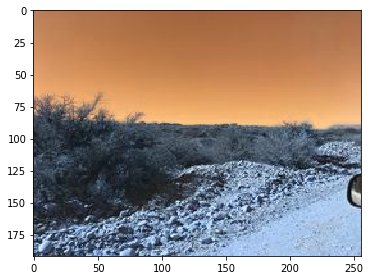

In [269]:
io.imshow(X_test[380])

In [270]:
y_test[380]

array([-65.31885376, -23.20575601])